# Introduction
It was a long time since I touched the Titanic data set, but I though it would be fun to try out Gradient Boosting on it!

I have not used Gradient Boosting before, so I thought I should start of with a familiar data set.
In this notebook I will opt to use the Light GBM package.

I will not do any new feature engineering, and will just straight up use the ones I engineered in my previous notebook `Second try with data exploration`.

# Import the data

In [9]:
import pandas as pd
import random
import math

In [11]:
training_data = pd.read_csv('titanic_train.csv')

In [13]:
age_distributions = training_data.groupby(['Pclass', 'Title'])['Age'].describe()

In [18]:
# Transformation functions
def set_title(row):
    if row['Sex'] == 'male':
        return "Man"
    elif row['Title'] in ['Miss', 'Mrs']:
        return row['Title']
    elif row['Age'] >= 31:
        return "Mrs"
    else:
        return "Miss"
    
def fill_missing_age(row):
    if row['Age'] and not math.isnan(row['Age']):
        return row['Age']
    else:
        dist = age_distributions.loc[(row['Pclass'], row['Title'])]
        return round(dist['mean'] + random.uniform(-dist['std'], dist['std']))
    
def title_feature(df):
    df['Title'] = df['Name'].str.extract(r'.*\,\s(.*?)\.', expand=False)
    df['Title'] = df.apply(set_title, axis=1)
    return df

def age_feature(df):
    # I always want the same "random" results
    random.seed(1)
    df['Age'] = df['Age'].fillna(df.apply(fill_missing_age, axis=1))
    
    df['Age Group'] = df['Age'].apply(
                            lambda x:
                               1 if x <= 3 else
                               2 if x <= 12 else
                               3 if x <= 17 else
                               4 if x <= 27 else
                               5 if x <= 39 else
                               6 if x <= 55 else
                               7)
    return df

def price_group_feature(df):
    fare_groups = [7.8541999999999996, 10.5, 21.679200000000002, 39.6875, 512.32920000000001]
    df['Price Group'] = df['Fare'].apply(
                            lambda x: 
                                1 if x < fare_groups[0] else
                                2 if x < fare_groups[1] else
                                3 if x < fare_groups[2] else
                                4 if x < fare_groups[3] else
                                5)
    return df

def family_size_feature(df):
    df['Family Size'] = df['Parch'] + df['SibSp'] + 1
    return df
    

# df should not include the target variable Survived
def transform_data(df):
    
    # Title
    df = title_feature(df)
    
    # Age
    df = age_feature(df)
    
    # Embarked
    df['Embarked'] = df['Embarked'].fillna('S')
    
    # Fare
    df = price_group_feature(df)
    
    # Family Size
    df = family_size_feature(df)
    
    # Drop unnecessary variables
    df = df[['Age Group', 'Pclass', 'Title', 'Price Group', 'Family Size', 'Embarked']]
    
    df = pd.get_dummies(df, columns=['Title', 'Embarked'])
    
    return df.copy()

In [19]:
X_train_df, Y_train_df = transform_data(training_data), training_data['Survived']

In [21]:
X_train_df.head()

,Age Group,Pclass,Price Group,Family Size,Title_Man,Title_Miss,Title_Mrs,Embarked_C,Embarked_Q,Embarked_S
0,4,3,1,2,1,0,0,0,0,1
1,5,1,5,2,0,0,1,1,0,0
2,4,3,2,1,0,1,0,0,0,1
3,5,1,5,2,0,0,1,0,0,1
4,5,3,2,1,1,0,0,0,0,1


In [24]:
X_train_df.shape

(891, 10)

In [33]:
X_train, y_train = X_train_df.values, Y_train_df.values

# Gradient Boosting
Let's explore Gradient Boosting by doing cross validation on some of it's hyper parameters.

In [39]:
from lightgbm.sklearn import LGBMClassifier

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [48]:
param_grid = {
    'objective' : ['binary'],
    'boosting_type' : ['gbdt'],
    'metric' : ['binary_logloss'],
    # There are many more casualties than survivors, so let's try the is_unbalance parameter
    'is_unbalance' : [False, True],
    'num_leaves' : [5, 10, 20, 30, 40, 50],
    'feature_fraction' : [.5, .8, .9, .95, 1.]
}

In [103]:
gsGBC = GridSearchCV(LGBMClassifier(), param_grid = param_grid, cv=StratifiedKFold(n_splits=3), scoring=["accuracy", "f1"], n_jobs= -1, verbose = 1, refit='accuracy')

In [104]:
gsGBC.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   31.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'objective': ['binary'], 'boosting_type': ['gbdt'], 'metric': ['binary_logloss'], 'is_unbalance': [False, True], 'num_leaves': [5, 10, 20, 30, 40, 50], 'feature_fraction': [0.5, 0.8, 0.9, 0.95, 1.0]},
       pre_dispatch='2*n_jobs', refit='accuracy',
       return_train_score='warn', scoring=['accuracy', 'f1'], verbose=1)

In [105]:
cv_result_dict = {
    'feature_fraction' : gsGBC.cv_results_['param_feature_fraction'],
    'is_unbalance' : gsGBC.cv_results_['param_is_unbalance'],
    'num_leaves' : gsGBC.cv_results_['param_num_leaves'],
    'mean_accuracy' : gsGBC.cv_results_['mean_test_accuracy'],
    'mean_f1' : gsGBC.cv_results_['mean_test_f1'],
}

In [106]:
cv_result_df = pd.DataFrame.from_dict(cv_result_dict)

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

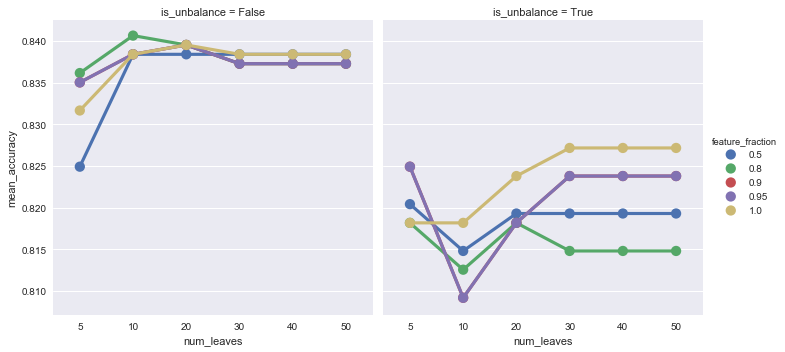

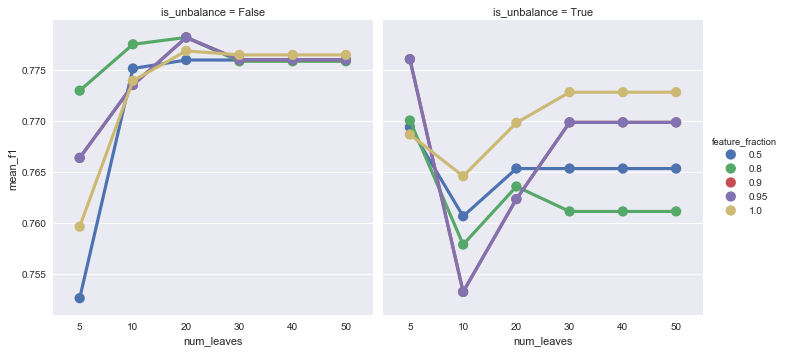

In [107]:
sns.factorplot(data=cv_result_df, x='num_leaves', hue='feature_fraction', y='mean_accuracy', col='is_unbalance', size=5)
sns.factorplot(data=cv_result_df, x='num_leaves', hue='feature_fraction', y='mean_f1', col='is_unbalance', size=5)

Clearly setting `is_unbalance=False` is better for accuracy, and for most hyper parameter choices it is better for f1 score as well.
I'll use the params that provided best accuracy, as this is the goal function on Kaggle, also, it gets one of the better f1 scores.

In [117]:
gsGBC.best_params_

{'boosting_type': 'gbdt',
 'feature_fraction': 0.8,
 'is_unbalance': False,
 'metric': 'binary_logloss',
 'num_leaves': 10,
 'objective': 'binary'}

In [109]:
best_clf = gsGBC.best_estimator_

## Test set

In [112]:
test_data = pd.read_csv('titanic_test.csv')
X_test_df = transform_data(test_data)
X_test = X_test_df.values

In [113]:
y_pred = best_clf.predict(X_test)

In [116]:
pd.DataFrame(index = test_data['PassengerId'], data=y_pred, columns=['Survived']).to_csv('titanic_submission_gbc.csv')

I got `0.75598` accuracy, which is very similar to my previous scores with this set of features. 

# Leaky Features
Let's try Greadient Boosting on the somewhat "leaky" feature set I used in my first notebook `Basic Machine Learning Models` which gave me 80% accuracy with a Maximum Entropy Classifier.

The leakiness comes from two features `SurvivingCOmpaions` called `DeadCompanions`.
I detect passangers traveling together by their ticket number, and then use the training data to check how many companions survived.
This would of coruse not be possible before the actual accident, thus making the feature very unrealistic.

In [147]:
def survival_features(df, survivial_source, test=False):
    tickets = survivial_source.groupby(['Ticket']).agg({'Survived' : 'sum', 'PassengerId' : 'count'}).rename(columns={'Survived' : 'SurvivedInCompany','PassengerId' : 'CompanySize'}).reset_index()
    df = df.merge(tickets, on = 'Ticket', how = 'left')
    if not test:
        df['Surviving Companions'] = df.apply(lambda row: row['SurvivedInCompany'] - row['Survived'], axis=1)
        df['Dead Companions'] = df.apply(lambda row: row['CompanySize'] - row['SurvivedInCompany'] + row['Survived'], axis=1)
    else:
        df['Surviving Companions'] = df.apply(lambda row: row['SurvivedInCompany'], axis=1)
        df['Dead Companions'] = df.apply(lambda row: row['CompanySize'] - row['SurvivedInCompany'], axis=1)
    return df

# Extract the features I liked the most from the Data Exploration notebook
def prepare_data(training_data, survivial_source, test=False):
    
    df = training_data.copy()
    
     # Title
    df = title_feature(df)
    
    # Age
    df = age_feature(df)
    
    # Embarked
    df['Embarked'] = df['Embarked'].fillna('S')
    
    # Fare
    df = price_group_feature(df)
    
    # Survival Features
    df = survival_features(df, survivial_source, test=test)
    
    # Drop unnecessary variables
    df = df[['Age Group', 'Pclass', 'Title', 'Price Group', 'Embarked', 'Surviving Companions', 'Dead Companions']]
    
    df = pd.get_dummies(df, columns=['Title', 'Embarked'])
    
    return df

In [148]:
training_data = pd.read_csv('titanic_train.csv')
test_data = pd.read_csv('titanic_test.csv')

In [149]:
X_train_df, Y_train_df = prepare_data(training_data, training_data), training_data['Survived']
X_test_df = prepare_data(test_data, training_data, test=True)

In [150]:
X_train, Y_train = X_train_df.values, Y_train_df.values
X_test = X_test_df.values

In [151]:
gsGBC = GridSearchCV(LGBMClassifier(), param_grid = param_grid, cv=StratifiedKFold(n_splits=3), scoring=["accuracy", "f1"], n_jobs= -1, verbose = 1, refit='accuracy')
gsGBC.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   24.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'objective': ['binary'], 'boosting_type': ['gbdt'], 'metric': ['binary_logloss'], 'is_unbalance': [False, True], 'num_leaves': [5, 10, 20, 30, 40, 50], 'feature_fraction': [0.5, 0.8, 0.9, 0.95, 1.0]},
       pre_dispatch='2*n_jobs', refit='accuracy',
       return_train_score='warn', scoring=['accuracy', 'f1'], verbose=1)

In [152]:
cv_result_dict = {
    'feature_fraction' : gsGBC.cv_results_['param_feature_fraction'],
    'is_unbalance' : gsGBC.cv_results_['param_is_unbalance'],
    'num_leaves' : gsGBC.cv_results_['param_num_leaves'],
    'mean_accuracy' : gsGBC.cv_results_['mean_test_accuracy'],
    'mean_f1' : gsGBC.cv_results_['mean_test_f1'],
}

In [153]:
cv_result_df = pd.DataFrame.from_dict(cv_result_dict)

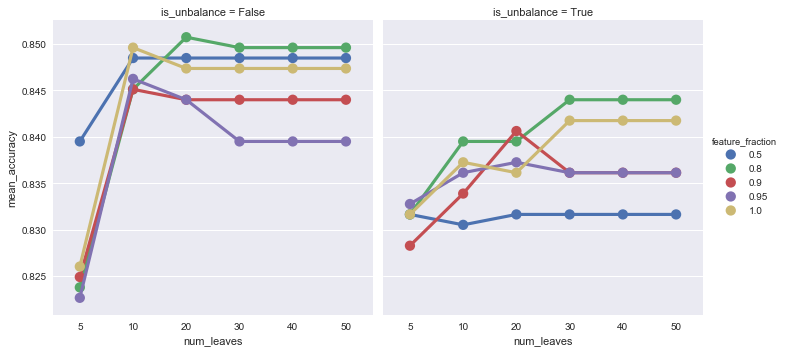

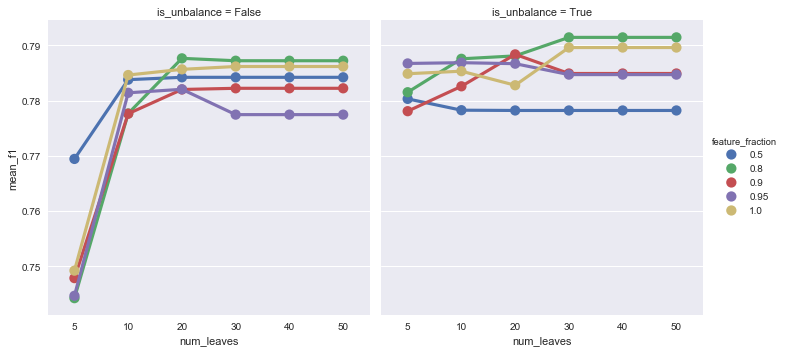

In [154]:
sns.factorplot(data=cv_result_df, x='num_leaves', hue='feature_fraction', y='mean_accuracy', col='is_unbalance', size=5)
sns.factorplot(data=cv_result_df, x='num_leaves', hue='feature_fraction', y='mean_f1', col='is_unbalance', size=5)

Cross validation accuracy of the best parameters is up to 85, with a new optimal set of hyper parameters!

In [155]:
best_clf = gsGBC.best_estimator_

In [156]:
y_pred = best_clf.predict(X_test)

In [157]:
pd.DataFrame(index = test_data['PassengerId'], data=y_pred, columns=['Survived']).to_csv('titanic_submission_gbc_2.csv')

Accuracy went up to 78.4%, which is still lower than what my Maximum Entropy Classifier scored on a similar feature set.

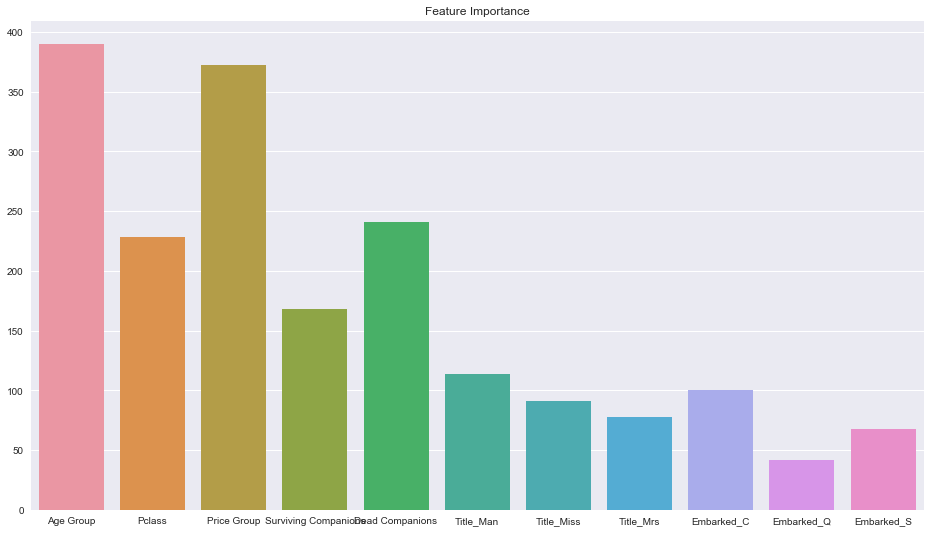

In [167]:
f, ax = plt.subplots(figsize=(16,9))
sns.barplot(x = X_test_df.columns, y= best_clf.feature_importances_)
ax.set_title('Feature Importance')

# Summary
I am still unable to beat my initial model + feature set. 

I would like to do some better comparsions, and also revisit the first feature set. The leaky metrics Surviving Companions and Dead Companions features have lots of null values for example, which could be problematic.